## Spam detection

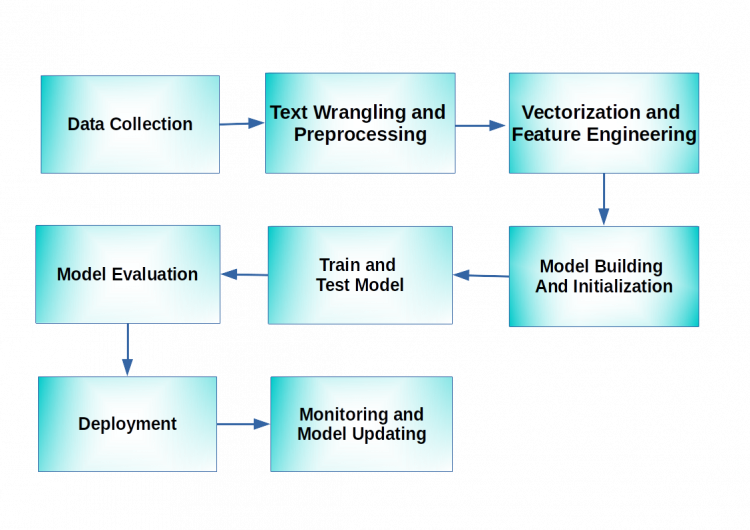

1. Read dataset and make it in proper format.
2. Encode labels
3. Convert all cases to lower
4. Remove punctuations
5. Remove Stopwords
6. Check stats of messages
7. Convert all texts into vectors
8. Import classifier
9. Train and test
10. Check the accuracy/confusion matrix.


In [40]:
#Import libs
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [41]:
sms = pd.read_csv('spam.csv',encoding='latin-1')
sms.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


**1.Feature engineering**

In [42]:
# Dataset has extra columns- Remove 
# Renaming v1 and v2
sms.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)

sms.rename(columns={'v1':'label','v2':'message'},inplace=True)

In [43]:
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [44]:
print ('Shape:',sms.shape)

Shape: (5572, 2)


# EDA

**Dealing with spam and ham -LABEL**

In [45]:
print ('ham and spam counts','\n',sms.label.value_counts())

ham and spam counts 
 ham     4825
spam     747
Name: label, dtype: int64


In [46]:
#Ratio of spam and ham
print ('spam ratio = ', round(len(sms[sms['label']=='spam']) / len(sms.label),2)*100,'%')
print ('ham ratio  = ', round(len(sms[sms['label']=='ham']) / len(sms.label),2)*100,'%')

spam ratio =  13.0 %
ham ratio  =  87.0 %


In [47]:
#New column for Length of message
sms['length'] = sms.message.str.len()
sms.head(5)

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [48]:
#Label encoding 0 and 1 on spam and ham
sms['label'].replace({'ham':0,'spam':1},inplace=True)

**Dealing with FEATURES**

In [49]:
# Convert all messages to lower case
sms['message'] = sms['message'].str.lower()

In [50]:
sms.head()

,label,message,length
0,0,"go until jurong point, crazy.. available only ...",111
1,0,ok lar... joking wif u oni...,29
2,1,free entry in 2 a wkly comp to win fa cup fina...,155
3,0,u dun say so early hor... u c already then say...,49
4,0,"nah i don't think he goes to usf, he lives aro...",61


**Regular Expressions**
- Some common regular expression metacharacters - copied from wikipedia

^ Matches the starting position within the string. In line-based tools, it matches the starting position of any line.

. Matches any single character (many applications exclude newlines, and exactly which characters are considered newlines is flavor-, character-encoding-, and platform-specific, but it is safe to assume that the line feed character is included). Within POSIX bracket expressions, the dot character matches a literal dot. For example, a.c matches "abc", etc., but [a.c] matches only "a", ".", or "c".

[ ] A bracket expression. Matches a single character that is contained within the brackets. For example, [abc] matches "a", "b", or "c". [a-z] specifies a range which matches any lowercase letter from "a" to "z". These forms can be mixed: [abcx-z] matches "a", "b", "c", "x", "y", or "z", as does [a-cx-z]. The - character is treated as a literal character if it is the last or the first (after the ^, if present) character within the brackets: [abc-], [-abc]. Note that backslash escapes are not allowed. The ] character can be included in a bracket expression if it is the first (after the ^) character: []abc].

[^ ] Matches a single character that is not contained within the brackets. For example, [^abc] matches any character other than "a", "b", or "c". [^a-z] matches any single character that is not a lowercase letter from "a" to "z". Likewise, literal characters and ranges can be mixed.

$ Matches the ending position of the string or the position just before a string-ending newline. In line-based tools, it matches the ending position of any line.

( ) Defines a marked subexpression. The string matched within the parentheses can be recalled later (see the next entry, \n). A marked subexpression is also called a block or capturing group. BRE mode requires ( ).

\n Matches what the nth marked subexpression matched, where n is a digit from 1 to 9. This construct is vaguely defined in the POSIX.2 standard. Some tools allow referencing more than nine capturing groups.

* Matches the preceding element zero or more times. For example, abc matches "ac", "abc", "abbbc", etc. [xyz] matches "", "x", "y", "z", "zx", "zyx", "xyzzy", and so on. (ab)* matches "", "ab", "abab", "ababab", and so on.

{m,n} Matches the preceding element at least m and not more than n times. For example, a{3,5} matches only "aaa", "aaaa", and "aaaaa". This is not found in a few older instances of regexes. BRE mode requires {m,n}.

In [51]:
# Replace email addresses with 'email'
sms['message'] = sms['message'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                 'emailaddress')

# Replace URLs with 'webaddress'
sms['message'] = sms['message'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                  'webaddress')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
sms['message'] = sms['message'].str.replace(r'£|\$', 'dollers')
    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
sms['message'] = sms['message'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                  'phonenumber')

    
# Replace numbers with 'numbr'
sms['message'] = sms['message'].str.replace(r'\d+(\.\d+)?', 'numbr')

In [52]:
# Remove punctuation
sms['message'] = sms['message'].str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
sms['message'] = sms['message'].str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
sms['message'] = sms['message'].str.replace(r'^\s+|\s+?$', '')

In [53]:
sms.head()

,label,message,length
0,0,go until jurong point crazy available only in ...,111
1,0,ok lar joking wif u oni,29
2,1,free entry in numbr a wkly comp to win fa cup ...,155
3,0,u dun say so early hor u c already then say,49
4,0,nah i don t think he goes to usf he lives arou...,61


# removing stopwords

In [54]:
# Remove stopwords
import string
import nltk
from nltk.corpus import  stopwords

stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

sms['message'] = sms['message'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

In [55]:
# New column (clean_length) after puncuations,stopwords removal
sms['clean_length'] = sms.message.str.len()
sms.head()

,label,message,length,clean_length
0,0,go jurong point crazy available bugis n great ...,111,82
1,0,ok lar joking wif oni,29,21
2,1,free entry numbr wkly comp win fa cup final tk...,155,139
3,0,dun say early hor c already say,49,31
4,0,nah think goes usf lives around though,61,38


In [56]:
# Total length removal
print ('Origian Length', sms.length.sum())
print ('Clean Length', sms.clean_length.sum())

Origian Length 446422
Clean Length 300564


# Visualising Label before and After EDA

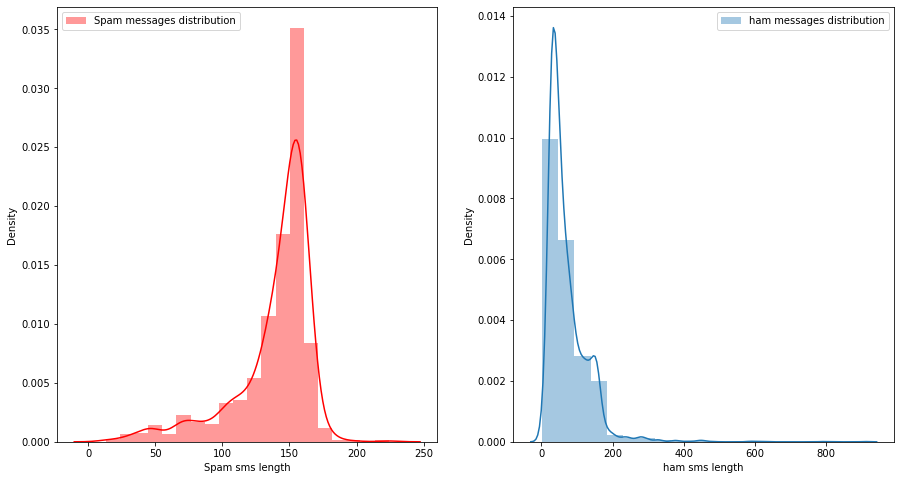

In [57]:
# Message distribution BEFORE cleaning
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(sms[sms['label']==1]['length'],bins=20,ax=ax[0],label='Spam messages distribution',color='r')

ax[0].set_xlabel('Spam sms length')
ax[0].legend()

sns.distplot(sms[sms['label']==0]['length'],bins=20,ax=ax[1],label='ham messages distribution')
ax[1].set_xlabel('ham sms length')
ax[1].legend()

plt.show()

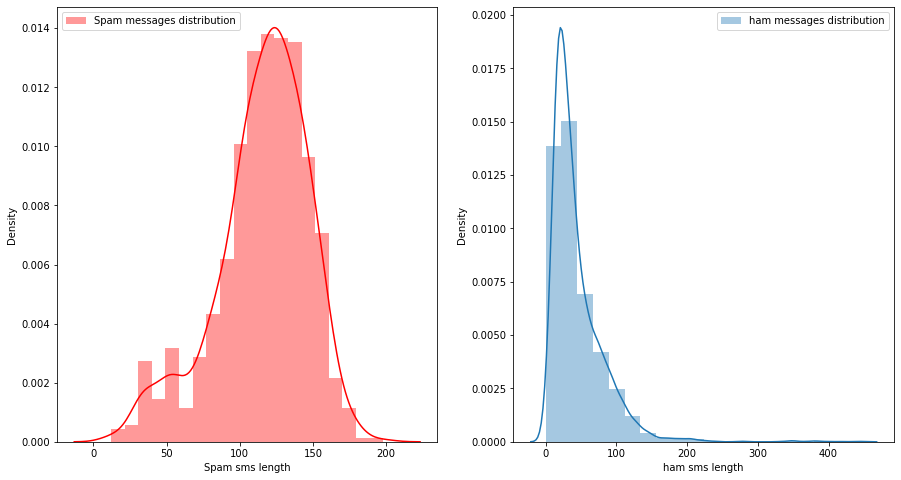

In [58]:
# Message distribution AFTER cleaning
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(sms[sms['label']==1]['clean_length'],bins=20,ax=ax[0],label='Spam messages distribution',color='r')
ax[0].set_xlabel('Spam sms length')
ax[0].legend()

sns.distplot(sms[sms['label']==0]['clean_length'],bins=20,ax=ax[1],label='ham messages distribution')
ax[1].set_xlabel('ham sms length')
ax[1].legend()

plt.show()

In [59]:
sms

,label,message,length,clean_length
0,0,go jurong point crazy available bugis n great ...,111,82
1,0,ok lar joking wif oni,29,21
2,1,free entry numbr wkly comp win fa cup final tk...,155,139
3,0,dun say early hor c already say,49,31
4,0,nah think goes usf lives around though,61,38
...,...,...,...,...
5567,1,numbrnd time tried numbr contact ådollersnumbr...,161,130
5568,0,ì_ b going esplanade fr home,37,28
5569,0,pity mood suggestions,57,21
5570,0,guy bitching acted like interested buying some...,125,79


# WORD CLOUD

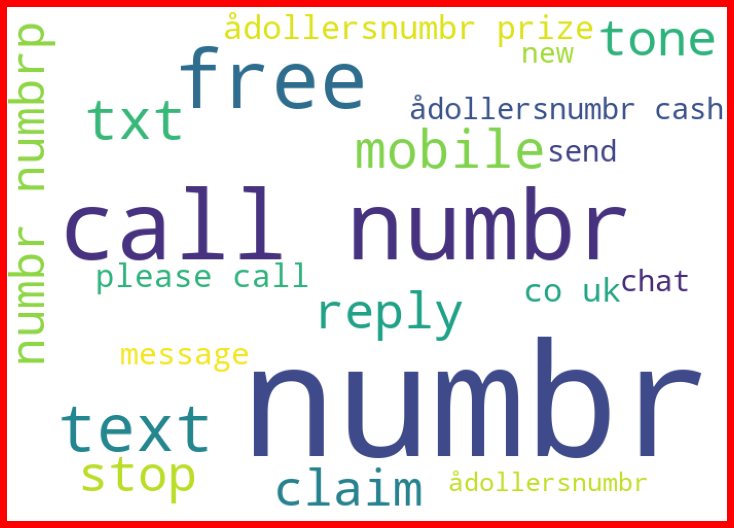

In [30]:
#Getting sense of loud words in spam 
from wordcloud import WordCloud


spams = sms['message'][sms['label']==1]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

We can clearly see, some of the words like "free, claim,cash etc" are indication of spams.

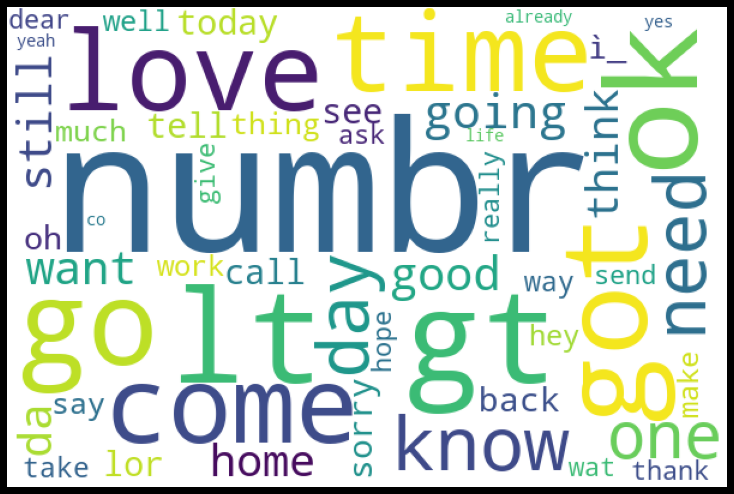

In [31]:
#Getting sense of loud words in ham 

hams = sms['message'][sms['label']==0]
spam_cloud = WordCloud(width=600,height=400,background_color='white',max_words=50).generate(' '.join(hams))
plt.figure(figsize=(10,8),facecolor='k')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Vectorization, splitting, training and predicting

In [60]:
#Convert text into vectors using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vec = TfidfVectorizer()
features = tf_vec.fit_transform(sms['message'])

In [61]:
sms

,label,message,length,clean_length
0,0,go jurong point crazy available bugis n great ...,111,82
1,0,ok lar joking wif oni,29,21
2,1,free entry numbr wkly comp win fa cup final tk...,155,139
3,0,dun say early hor c already say,49,31
4,0,nah think goes usf lives around though,61,38
...,...,...,...,...
5567,1,numbrnd time tried numbr contact ådollersnumbr...,161,130
5568,0,ì_ b going esplanade fr home,37,28
5569,0,pity mood suggestions,57,21
5570,0,guy bitching acted like interested buying some...,125,79


In [33]:
X = features
y = sms['label']

In [62]:
X

<5572x7844 sparse matrix of type '<class 'numpy.float64'>'
	with 46507 stored elements in Compressed Sparse Row format>

In [34]:
# Instantiate MultinomialNB classifier
from sklearn.naive_bayes import MultinomialNB
naive = MultinomialNB()

In [35]:
# Train and predict

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#train 
X_train,x_test,Y_train,y_test = train_test_split(X,y,random_state=42)
naive.fit(X_train,Y_train)

#predict
y_pred= naive.predict(x_test)
print ('Final score = > ', accuracy_score(y_test,y_pred))

Final score = >  0.9705671213208902


In [36]:
y_pred

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1202
           1       1.00      0.79      0.88       191

    accuracy                           0.97      1393
   macro avg       0.98      0.89      0.93      1393
weighted avg       0.97      0.97      0.97      1393



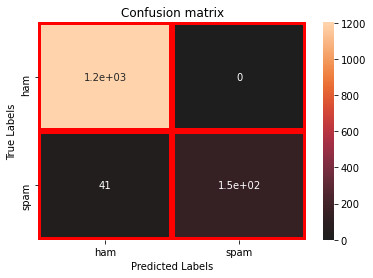

In [38]:
# plot confusion matrix heatmap
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['ham','spam'])
ax.yaxis.set_ticklabels(['ham','spam'])
plt.show()

In [39]:
conf_mat

array([[1202,    0],
       [  41,  150]], dtype=int64)